In [1]:
import re
import nltk
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.downloader import load
from collections import defaultdict, Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Conv1D, AveragePooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Preprocessing

In [2]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
df.shape

(50000, 2)

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


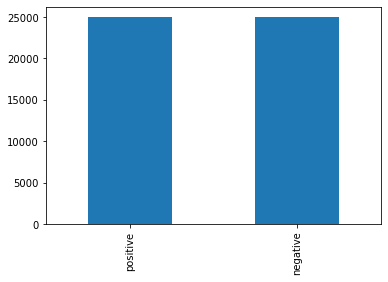

In [5]:
df['sentiment'].value_counts().plot(kind='bar');

In [6]:
X = df['review'].str.lower()
y = df['sentiment'].map({'negative': 0, 'positive': 1})

In [7]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

def remove_urls(text):
    return re.sub(r'https?://\S+', '', text)

stopwords = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

def remove_stopwords(text):
    s = []
    for word in text.split():
        if word not in stopwords:
            s.append(lemmatizer.lemmatize(word))
    a = s[:]
    s.clear()
    return ' '.join(a)

In [8]:
def preprocessing(x):
    x = x.lower()
    x = remove_html_tags(x)
    x = remove_urls(x)
    x = remove_stopwords(x)
    x = re.sub("[^a-zA-Z]"," ",x)
    return x

In [9]:
X = X.apply(preprocessing)

In [93]:
corpus = [nltk.word_tokenize(word) for word in X]

In [94]:
word_freq = defaultdict(int)
for sent in corpus:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

98798

In [95]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['movie', 's', 'film', 'one', 'like', 'i', 'good', 'it', 'time', 'the']

## Bigrams

In [96]:
phrases = Phrases(corpus, min_count=30, progress_per=10000)

In [97]:
bigram = Phraser(phrases)

In [98]:
sentences = bigram[corpus]

# LSTM

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
vocab_size = 30000
max_length = 500
trunc_type = 'post'
oov_tok = 'OOV'

token = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
token.fit_on_texts(X_train)
index_word = token.index_word

# Convert texts to sequences
train_seq = token.texts_to_sequences(X_train)
val_seq = token.texts_to_sequences(X_valid)

# Sequence padding
# Since the sequences have different length, then we use padding method to put all sequences to the same length. 
# The parameter "maxlen" sets the maximum length of the output sequence. 
#    + If length of the input sequence is larger than "maxlen", then it is trunced to keep only #maxlen words, (truncating = 'pre': keep the previous part of the sequence; truncating = 'post': keep the posterior part of the sequence).
#    + If length of the input sequence is smaller than "maxlen", then 0 elements will be padded into the previous part of sequence (if padding = 'pre' - by defaut) or in the tail of the sequence (if padding = 'post').

train_pad = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
val_pad = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [21]:
embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(AveragePooling1D(pool_size = 2))
model.add(Bidirectional(LSTM(200, dropout = 0.5)))
model.add(Dense(1, activation = 'sigmoid'))

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics='accuracy')

In [23]:
history = model.fit(train_pad, y_train, epochs = 3, batch_size = 128,
             validation_data = (val_pad, y_valid))

Epoch 1/3
313/313 [==============================] - 431s 1s/step - loss: 0.5106 - accuracy: 0.7276 - val_loss: 0.2977 - val_accuracy: 0.8805
Epoch 2/3
313/313 [==============================] - 399s 1s/step - loss: 0.2386 - accuracy: 0.9099 - val_loss: 0.2576 - val_accuracy: 0.8951
Epoch 3/3
313/313 [==============================] - 401s 1s/step - loss: 0.1758 - accuracy: 0.9369 - val_loss: 0.2601 - val_accuracy: 0.8951


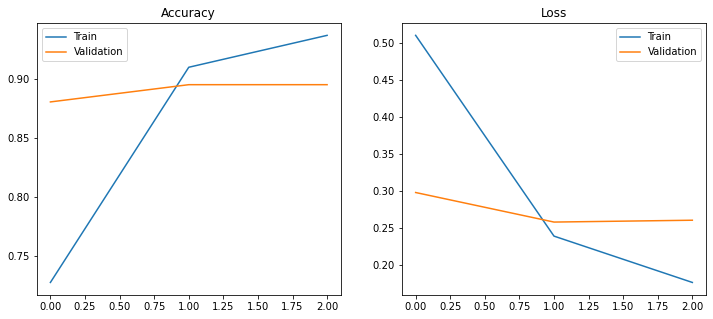

In [24]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.title('Loss')

plt.show()

## Real life testing

In [42]:
testing_sequences = pd.Series([
    'This movie is actually good',
    'I love this movie',
    'Something strange',
    'It is bad',
    'I think it is terrible and awful, worst movie ever',
    'Meh',
    'I admire this perfect movie',
    'Good',
    'Well, I love this',
    'Wow I love this',
    'I drop this',
    'Stop this now'
])

In [43]:
sequences_to_test = testing_sequences.apply(preprocessing)
test_seq = token.texts_to_sequences(sequences_to_test)
test_pad = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [81]:
# Negative if probability < threshold, otherwise positive
y_pred_proba = model.predict(test_pad)

In [82]:
y_pred_proba

array([[0.5702037 ],
       [0.5710122 ],
       [0.47049463],
       [0.46571827],
       [0.04319534],
       [0.5096562 ],
       [0.6680503 ],
       [0.5441409 ],
       [0.6042753 ],
       [0.54709446],
       [0.50823915],
       [0.54313457]], dtype=float32)

In [91]:
threshold = 0.54
y_pred = np.array(['Negative' if proba < threshold else 'Positive' for proba in y_pred_proba])

In [92]:
pd.DataFrame({'y_pred': y_pred}, index=testing_sequences)

,y_pred
This movie is actually good,Positive
I love this movie,Positive
Something strange,Negative
It is bad,Negative
"I think it is terrible and awful, worst movie ever",Negative
Meh,Negative
I admire this perfect movie,Positive
Good,Positive
"Well, I love this",Positive
Wow I love this,Positive


### Conclusion 
As we can see it works quite good, but of course not perfect. <br>
The accuracies of this model on the training set is 93.69%, on the validation set is 89.51%.

### Possible improvements:
+ 1) Find ideal threshold for better classification
+ 2) Change dimension of the embedding layer
+ 3) Change hyperparameter values as number of neurons in LSTM layer and other

# Word2Vec embeddings + LSTM

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

In [99]:
cores = multiprocessing.cpu_count()

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `vector_size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [100]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=250,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=15,
                     workers=cores-1)

## Building the Vocabulary Table

In [101]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)

CPU times: user 9.05 s, sys: 3.39 ms, total: 9.06 s
Wall time: 9.06 s


## Train model

In [102]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 17min 28s, sys: 2.94 s, total: 17min 31s
Wall time: 6min


(108753319, 181188060)

In [103]:
w2v_model.init_sims(replace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  """Entry point for launching an IPython kernel.


## Exploring the model

In [152]:
w2v_model.wv.most_similar(positive=["good"])

[('great', 0.6897010207176208),
 ('bad', 0.6736197471618652),
 ('decent', 0.6735561490058899),
 ('really', 0.572717010974884),
 ('interesting', 0.569281280040741),
 ('pretty_good', 0.5521739721298218),
 ('nice', 0.5517479181289673),
 ('excellent', 0.5419151186943054),
 ('though', 0.5409290790557861),
 ('entertaining', 0.5336818695068359)]

In [153]:
w2v_model.wv.most_similar(positive=["bad"])

[('awful', 0.7702465057373047),
 ('horrible', 0.6980015635490417),
 ('terrible', 0.6967405676841736),
 ('good', 0.6736196279525757),
 ('stupid', 0.6179767847061157),
 ('poor', 0.567340075969696),
 ('acting', 0.5497263073921204),
 ('cheesy', 0.5487834811210632),
 ('lame', 0.5412358045578003),
 ('lousy', 0.5396344065666199)]

In [156]:
w2v_model.wv.most_similar(positive=["like"])

[('think', 0.5166852474212646),
 ('know', 0.4642770290374756),
 ('say', 0.43992915749549866),
 ('kind', 0.4377787411212921),
 ('look_like', 0.4185235798358917),
 ('really', 0.4156492352485657),
 ('movies', 0.4053240716457367),
 ('mean', 0.40435585379600525),
 ('better', 0.4018464982509613),
 ('this', 0.40129297971725464)]

In [157]:
w2v_model.wv.most_similar(positive=["really"])

[('it', 0.698783814907074),
 ('actually', 0.693743109703064),
 ('movie', 0.6836764216423035),
 ('think', 0.6623119115829468),
 ('all', 0.6438000202178955),
 ('even', 0.6381530165672302),
 ('this', 0.6250959038734436),
 ('that', 0.618579626083374),
 ('though', 0.6124809980392456),
 ('thing', 0.6087504029273987)]

In [158]:
w2v_model.wv.most_similar(positive=["real"])

[('realistic', 0.48621541261672974),
 ('true', 0.4856182038784027),
 ('actual', 0.45295801758766174),
 ('really', 0.4500250220298767),
 ('kind', 0.4180455803871155),
 ('genuine', 0.4130459725856781),
 ('much', 0.40434470772743225),
 ('story', 0.3957947790622711),
 ('sort', 0.38574397563934326),
 ('actually', 0.3856559097766876)]

In [159]:
w2v_model.wv['good'].shape

(250,)

## t-SNE Visualization 

In [160]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 250), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Reduces the dimensionality with PCA
    reduc = PCA(n_components=min(11 + len(list_names), 50)).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


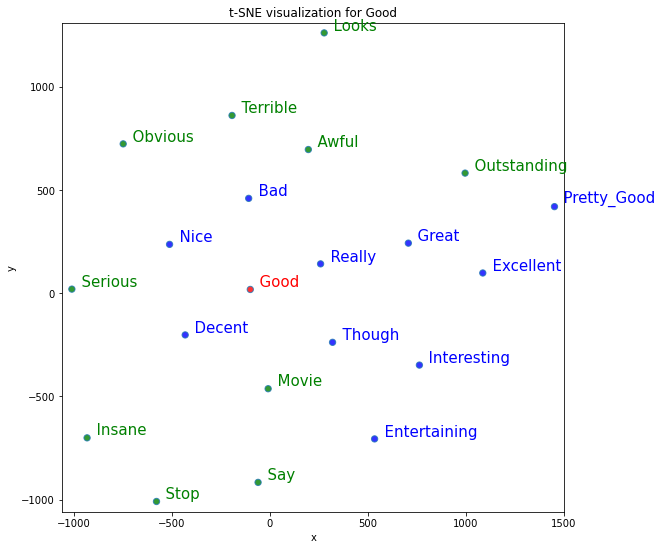

In [161]:
tsnescatterplot(w2v_model, 'good', ['movie', 'awful', 'say', 'obvious', 'serious', 'looks', 'outstanding', 'stop', 'insane', 'terrible'])

## Train LSTM on our embedding vectors

### Create embedding matrix for embedding layer

In [133]:
vocabulary = list(w2v_model.wv.key_to_index)

In [134]:
word_vec_dict = {}
for word in vocabulary:
  word_vec_dict[word] = w2v_model.wv.get_vector(word)

In [135]:
len(word_vec_dict)

21237

In [153]:
word_vec_dict.get('movie').shape

(250,)

In [29]:
token = Tokenizer(oov_token = oov_tok)
token.fit_on_texts(X)
vocabulary_size = len(token.word_index) + 1

In [30]:
vocabulary_size

98805

In [204]:
embedding_matrix = np.zeros(shape = (vocabulary_size, 250))
for word, i in token.word_index.items():
  embedding_vector = word_vec_dict.get(word)
  if embedding_vector is not None:  # word is in the vocabulary learned by the w2v model
    embedding_matrix[i] = embedding_vector
  # if word is not found then embedding_vector corressponding to that vector will stay zero.

In [205]:
embedding_matrix[3]

array([-0.02765566, -0.05996536, -0.00358983, -0.09400292, -0.110151  ,
       -0.03752925,  0.05155565,  0.10242907,  0.06944045,  0.0011009 ,
       -0.0669326 ,  0.01686911, -0.01435277, -0.10043816,  0.03241957,
       -0.15127049, -0.09838786, -0.02054627,  0.07220386, -0.0331947 ,
       -0.04501513, -0.01499045,  0.02583852, -0.09971074,  0.06678975,
       -0.03337855, -0.08344575, -0.07169088,  0.09581955,  0.1029719 ,
        0.09456196,  0.07066949, -0.14759861, -0.05389517, -0.04300665,
        0.09202819, -0.11032216,  0.02688146,  0.04043648, -0.04735028,
        0.11075338, -0.02158537, -0.01816455,  0.01776598, -0.04034676,
       -0.10753975, -0.02811786, -0.01566339,  0.08430595, -0.06351706,
        0.10982201, -0.19100624, -0.07032067, -0.04153463,  0.10450625,
        0.03185039,  0.1340594 , -0.00546976, -0.05332749, -0.12447048,
       -0.03825891, -0.10336313,  0.03072145,  0.06354524, -0.00222191,
        0.06809843,  0.0437584 ,  0.11736552, -0.04179469, -0.00

## Train model

In [35]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(AveragePooling1D(pool_size = 2))
    model.add(Bidirectional(LSTM(200, dropout = 0.5)))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

model = build_model(
    embedding_matrix=embedding_matrix,
    input_length=250)

2023-02-04 10:37:32.289854: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [188]:
w2v_model.wv.vectors.shape

(21237, 250)

In [189]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 250)          24701250  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 250, 32)           24032     
_________________________________________________________________
average_pooling1d_7 (Average (None, 125, 32)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 400)               372800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 401       
Total params: 25,098,483
Trainable params: 397,233
Non-trainable params: 24,701,250
_________________________________________________________________


In [207]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics='accuracy')

In [191]:
history = model.fit(train_pad, y_train, epochs = 3, batch_size = 128,
             validation_data = (val_pad, y_valid))

Epoch 1/3
313/313 [==============================] - 441s 1s/step - loss: 0.6579 - accuracy: 0.5994 - val_loss: 0.5784 - val_accuracy: 0.6994
Epoch 2/3
313/313 [==============================] - 437s 1s/step - loss: 0.5823 - accuracy: 0.6982 - val_loss: 0.5480 - val_accuracy: 0.7264
Epoch 3/3
313/313 [==============================] - 425s 1s/step - loss: 0.5426 - accuracy: 0.7301 - val_loss: 0.5348 - val_accuracy: 0.7398


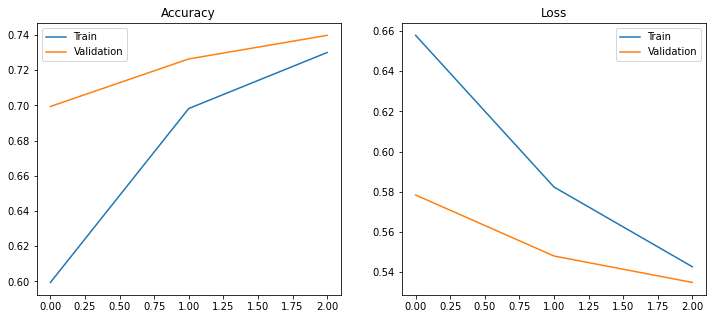

In [193]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.title('Loss')

plt.show()

## Real life testing

In [194]:
test_pad

array([[   2,   81,    8, ...,    0,    0,    0],
       [  38,    2,    0, ...,    0,    0,    0],
       [  65,  587,    0, ...,    0,    0,    0],
       ...,
       [1192,   38,    0, ...,    0,    0,    0],
       [1675,    0,    0, ...,    0,    0,    0],
       [ 419,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [195]:
y_pred_proba = model.predict(test_pad)

In [196]:
y_pred_proba

array([[0.5106009 ],
       [0.546876  ],
       [0.5075972 ],
       [0.48413202],
       [0.44191706],
       [0.5130514 ],
       [0.5325869 ],
       [0.52494615],
       [0.5704006 ],
       [0.5626123 ],
       [0.50874865],
       [0.5143063 ]], dtype=float32)

In [201]:
threshold = 0.52
y_pred = np.array(['Negative' if proba < threshold else 'Positive' for proba in y_pred_proba])

In [202]:
pd.DataFrame({'y_pred': y_pred}, index=testing_sequences)

,y_pred
This movie is actually good,Negative
I love this movie,Positive
Something strange,Negative
It is bad,Negative
"I think it is terrible and awful, worst movie ever",Negative
Meh,Negative
I admire this perfect movie,Positive
Good,Positive
"Well, I love this",Positive
Wow I love this,Positive


# FastText + LSTM

In [36]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [4]:
ft_vectors = load('fasttext-wiki-news-subwords-300')

In [5]:
ft_vectors.most_similar('perfect')

[('ideal', 0.7845567464828491),
 ('imperfect', 0.7837276458740234),
 ('perfection', 0.7817169427871704),
 ('near-perfect', 0.7781161069869995),
 ('flawless', 0.7654388546943665),
 ('unperfect', 0.7530180215835571),
 ('perfectible', 0.7495022416114807),
 ('perfect-', 0.7464147210121155),
 ('non-perfect', 0.7448152899742126),
 ('perfectly', 0.7336483597755432)]

In [6]:
ft_vectors.most_similar('crazy')

[('insane', 0.8300460577011108),
 ('mad', 0.8181312084197998),
 ('half-crazy', 0.7894324660301208),
 ('weird', 0.7866970896720886),
 ('whacky', 0.7845840454101562),
 ('bonkers', 0.7789973616600037),
 ('crazy-making', 0.7789759635925293),
 ('crazy-eyed', 0.7740947008132935),
 ('wacky', 0.7720527052879333),
 ('stupid', 0.7717647552490234)]

In [7]:
ft_vectors.most_similar('violent')

[('violence', 0.7621110081672668),
 ('brutal', 0.7518234252929688),
 ('ultra-violent', 0.7410402297973633),
 ('murderous', 0.7377474308013916),
 ('hyper-violent', 0.735873818397522),
 ('ultraviolent', 0.7307270765304565),
 ('non-violent', 0.7275790572166443),
 ('violence-prone', 0.716448187828064),
 ('vicious', 0.7156386971473694),
 ('abusive', 0.7012999653816223)]

### Get embedding matrix for embedding layer

In [11]:
vocabulary = list(ft_vectors.key_to_index)

In [12]:
ft_dict = {}
for word in vocabulary:
  ft_dict[word] = ft_vectors.get_vector(word)

In [15]:
ft_dict['hello'].shape

(300,)

In [16]:
len(ft_dict)

999999

In [32]:
embedding_matrix = np.zeros(shape = (vocabulary_size, 300))
for word, i in token.word_index.items():
  embedding_vector = ft_dict.get(word)
  if embedding_vector is not None:  # word is in the vocabulary learned by the fasttext model
    embedding_matrix[i] = embedding_vector
  # if word is not found then embedding_vector corressponding to that vector will stay zero.

In [33]:
embedding_matrix[10]

array([-6.66130008e-03, -1.52089998e-01,  1.14590004e-02,  1.08220000e-02,
        2.99050007e-02,  5.49900010e-02, -3.30349989e-02, -1.39219999e-01,
        1.16499998e-01, -2.42669992e-02, -4.61679995e-02,  3.72850001e-02,
        2.50100009e-02,  4.34570014e-02,  3.15679982e-02, -3.65979993e-03,
        7.74170011e-02,  2.47130003e-02,  1.15939997e-01,  3.89950015e-02,
       -1.34779997e-02,  3.01290005e-02, -8.15680027e-02,  6.45819977e-02,
       -4.72769998e-02,  3.69810015e-02,  1.66560002e-02, -2.82049999e-02,
        2.58249987e-04,  8.90970044e-03, -4.54250015e-02,  1.02810003e-02,
       -2.78880005e-03, -1.91699997e-01, -7.25359991e-02, -4.88899983e-02,
        3.36610004e-02,  1.08620003e-02,  1.79309994e-02,  2.21239999e-02,
       -4.12379988e-02, -8.75720009e-02,  1.71510000e-02,  1.49850000e-03,
       -1.44480001e-02, -6.75109997e-02,  4.03669998e-02, -1.31789995e-02,
       -4.91309986e-02,  3.82289998e-02, -1.53040001e-02, -2.84400005e-02,
        4.77759987e-02,  

## Train model

In [36]:
model = build_model(
    embedding_matrix=embedding_matrix,
    input_length=300)

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          29641500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
average_pooling1d_1 (Average (None, 150, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               372800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 30,043,533
Trainable params: 402,033
Non-trainable params: 29,641,500
_________________________________________________________________


In [38]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics='accuracy')

In [39]:
history = model.fit(train_pad, y_train, epochs = 3, batch_size = 128,
             validation_data = (val_pad, y_valid))

2023-02-04 10:38:32.447017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
313/313 [==============================] - 543s 2s/step - loss: 0.6738 - accuracy: 0.5673 - val_loss: 0.6303 - val_accuracy: 0.6481
Epoch 2/3
313/313 [==============================] - 553s 2s/step - loss: 0.5922 - accuracy: 0.6882 - val_loss: 0.5678 - val_accuracy: 0.7119
Epoch 3/3
313/313 [==============================] - 552s 2s/step - loss: 0.5612 - accuracy: 0.7178 - val_loss: 0.5186 - val_accuracy: 0.7460


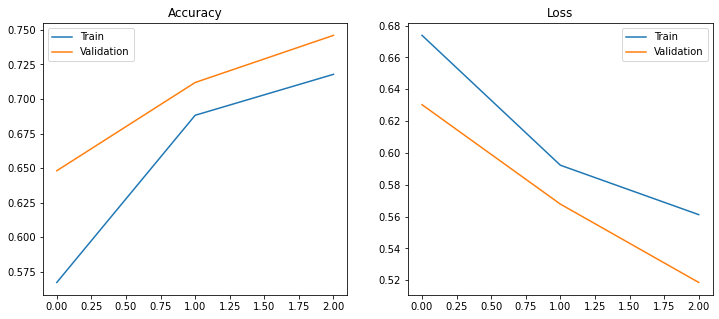

In [40]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.title('Loss')

plt.show()

## Real life testing

In [44]:
test_pad

array([[   2,   81,    8, ...,    0,    0,    0],
       [  38,    2,    0, ...,    0,    0,    0],
       [  65,  602,    0, ...,    0,    0,    0],
       ...,
       [1238,   38,    0, ...,    0,    0,    0],
       [1676,    0,    0, ...,    0,    0,    0],
       [ 423,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [45]:
y_pred_proba = model.predict(test_pad)

In [46]:
y_pred_proba

array([[0.49992025],
       [0.53071696],
       [0.51381844],
       [0.4533305 ],
       [0.45916316],
       [0.51242316],
       [0.5154389 ],
       [0.5070593 ],
       [0.55287254],
       [0.554914  ],
       [0.51207   ],
       [0.50206757]], dtype=float32)

In [49]:
threshold = 0.52
y_pred = np.array(['Negative' if proba < threshold else 'Positive' for proba in y_pred_proba])

In [50]:
pd.DataFrame({'y_pred': y_pred}, index=testing_sequences)

,y_pred
This movie is actually good,Negative
I love this movie,Positive
Something strange,Negative
It is bad,Negative
"I think it is terrible and awful, worst movie ever",Negative
Meh,Negative
I admire this perfect movie,Negative
Good,Negative
"Well, I love this",Positive
Wow I love this,Positive


# BERT

In [10]:
import torch
import torch.nn as nn

from torchtext import data
from torchtext.datasets import IMDB
from transformers import BertTokenizerFast, AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
bert = AutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
# truncate sequence
max_length = 512
X = [val[:max_length] for val in X]

### Tokenization

In [15]:
# encode text
sent_id = tokenizer.batch_encode_plus(X, padding=True, return_token_type_ids=False)

<AxesSubplot:>

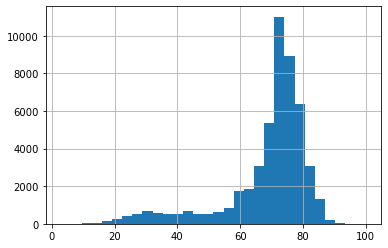

In [16]:
# get length of all the messages
seq_len = [len(i.split()) for i in X]

pd.Series(seq_len).hist(bins = 30)

In [17]:
max_seq_len = 85

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Convert Integer Sequences to Tensors

In [20]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_valid.tolist())

### Create dataloaders

In [21]:
#define a batch size
batch_size = 128

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze BERT parameters

In [22]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Define model architecture

In [26]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 2)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask).pooler_output
        # print(self.bert(sent_id, attention_mask=mask).last_hidden_state.shape)
        output = self.drop(cls_hs)
        output = self.out(output)
        return output

In [27]:
model = BERT(bert)
model = model.to(device)

### Fine tune BERT model

In [28]:
%%time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 3
running_loss = 0.0

for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        optimizer.zero_grad()
        preds = model(sent_id, mask)
        loss = criterion(preds.view(-1, 2), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1} loss: {running_loss / len(train_dataloader)}')
    running_loss = 0.0

Epoch 1 loss: 0.6991224254662998
Epoch 2 loss: 0.6905025986436838
Epoch 3 loss: 0.6844094568928971
CPU times: user 4min 32s, sys: 311 ms, total: 4min 32s
Wall time: 4min 34s


In [30]:
# evaluate on the validation set after each epoch
model.eval()  # set model to evaluation mode
with torch.no_grad():
    val_loss = 0.0
    for sent_id, mask, labels in val_dataloader:
        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)
        preds = model(sent_id, mask)
        loss = criterion(preds, labels)
        val_loss += loss.item()
    print(f'Validation loss: {val_loss / len(val_dataloader)}')

Validation loss: 0.6727096076253094
